In [ ]:
!pip3 uninstall torch torchvision --yes

In [ ]:
!pip3 install torch==1.11.0 torchvision==0.12

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

import time
import os
import copy
import random

import tqdm

cudnn.benchmark = True
plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.11.0+cu102
Torchvision Version:  0.12.0+cu102


In [2]:
train = pd.read_csv(r'/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv(r'/kaggle/input/digit-recognizer/test.csv')

In [3]:
y_train = train['label']
X_train = train.drop('label', axis=1)

In [4]:
X_train /= 255.
test /= 255.

In [5]:
X_train.shape

(42000, 784)

In [6]:
y_train.shape

(42000,)

In [23]:
dataset_sizes = {'train': len(X_train), 'test':len(test)}

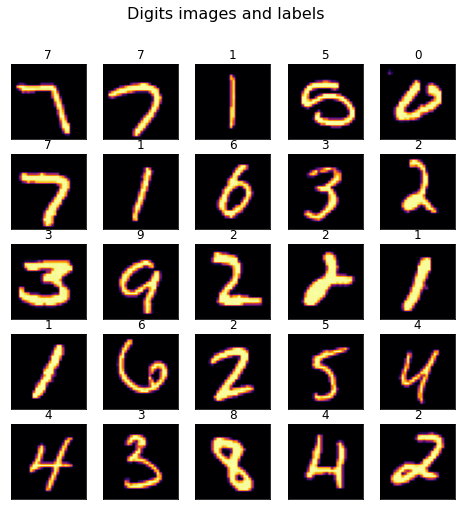

In [7]:
fig, ax = plt.subplots(5, 5, figsize=(8, 8))
fig.suptitle('Digits images and labels', fontsize=16)
ax = ax.ravel()
for i in range(25):
    sample_n = random.randint(0, X_train.shape[0])
    ax[i].imshow(np.array(X_train.iloc[sample_n]).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(y_train[sample_n], fontsize = 12)

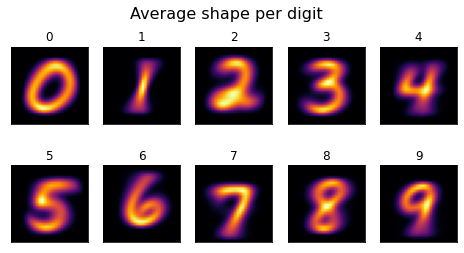

In [8]:
fig, ax = plt.subplots(2, 5, figsize=(8, 4))
fig.suptitle('Average shape per digit', fontsize=16)

ax = ax.ravel()

for i in range(10):
    ax[i].imshow(np.array(train[train['label'] == i].drop('label', axis=1).mean()).reshape(28, 28), cmap='inferno')
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)
    ax[i].set_title(i, fontsize = 12)

In [9]:
X_train_array = np.array(X_train)
X_train_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
test_array = np.array(test)
test_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
X_train_array = X_train_array.reshape(42000, 1, 28, 28)
test_array = test_array.reshape(-1, 1, 28, 28)

In [12]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.ToTensor(),
    ]),
}

In [39]:
train_data = []
for i in range(len(X_train_array)):
   train_data.append([X_train_array[i], y_train[i]])
dataloaders = {'train': torch.utils.data.DataLoader(train_data, batch_size=32,
                                             shuffle=True, num_workers=4)
              ,'test':  torch.utils.data.DataLoader(test_array, batch_size=20,
                                             shuffle=False, num_workers=4)}

In [14]:
# training_loader = dataloaders['train']
# dataiter = iter(training_loader)
# images, labels = dataiter.next()
# images = images.float()

In [68]:
model_ft = models.regnet_y_400mf(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft.stem[0] = torch.nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [69]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    model.to(device)
    since = time.time()

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch_num, [inputs, labels] in enumerate(tqdm.tqdm(dataloaders[phase])):
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    torch.save(model.state_dict(), 'model.pt')

    return model

In [70]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0003)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
exp_lr_scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer_ft, T_0=5, T_mult=1, eta_min=0, last_epoch=-1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


100%|██████████| 1313/1313 [01:33<00:00, 14.06it/s]


train Loss: 0.4943 Acc: 0.8381

Epoch 1/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.15it/s]


train Loss: 0.1424 Acc: 0.9571

Epoch 2/24
----------


100%|██████████| 1313/1313 [01:33<00:00, 14.00it/s]


train Loss: 0.1017 Acc: 0.9697

Epoch 3/24
----------


100%|██████████| 1313/1313 [01:33<00:00, 14.01it/s]


train Loss: 0.1017 Acc: 0.9713

Epoch 4/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


train Loss: 0.0882 Acc: 0.9758

Epoch 5/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


train Loss: 0.0316 Acc: 0.9904

Epoch 6/24
----------


100%|██████████| 1313/1313 [01:33<00:00, 14.11it/s]


train Loss: 0.0291 Acc: 0.9911

Epoch 7/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.16it/s]


train Loss: 0.0441 Acc: 0.9872

Epoch 8/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.18it/s]


train Loss: 0.0472 Acc: 0.9866

Epoch 9/24
----------


100%|██████████| 1313/1313 [01:33<00:00, 14.05it/s]


train Loss: 0.0599 Acc: 0.9840

Epoch 10/24
----------


100%|██████████| 1313/1313 [01:33<00:00, 14.10it/s]


train Loss: 0.0225 Acc: 0.9937

Epoch 11/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


train Loss: 0.0137 Acc: 0.9959

Epoch 12/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.12it/s]


train Loss: 0.0242 Acc: 0.9929

Epoch 13/24
----------


100%|██████████| 1313/1313 [01:33<00:00, 14.04it/s]


train Loss: 0.0322 Acc: 0.9904

Epoch 14/24
----------


100%|██████████| 1313/1313 [01:32<00:00, 14.14it/s]


train Loss: 0.0309 Acc: 0.9910

Epoch 15/24
----------


 58%|█████▊    | 763/1313 [00:54<00:40, 13.60it/s]

In [58]:
def prediction(model, data_loader):
    model.to(device)
    model.eval()
    test_pred = torch.LongTensor()
    with torch.no_grad():        
        for i, data in enumerate(tqdm.tqdm(data_loader)):
            data = data.float()
            data = data.to(device)

            output = model(data)

            _,pred = torch.max(output,1) 
            test_pred = torch.cat((test_pred,pred.cpu()),dim=0)
          
        
    return test_pred

In [59]:
test_loader = dataloaders['test']
test_pred = prediction(model_ft, test_loader)
predictions = test_pred.numpy()

100%|██████████| 1400/1400 [00:24<00:00, 57.76it/s]


In [60]:
submission = pd.read_csv(r'/kaggle/input/digit-recognizer/sample_submission.csv')

In [61]:
submission['Label'] = predictions

In [62]:
submission.to_csv('/kaggle/working/t_submission.csv',index = False)

In [63]:
test.shape

(28000, 784)